# Introduction

In this notebook we will look at some techniques for differential cell abundance analysis when you have multiple samples.

# Load packages

In [1]:
import pandas as pd
import numpy as np
import scanpy as sc

In [2]:
import matplotlib.pyplot as plt

# Load example data

In [11]:
input_path = "/Users/francesca.drummer/Documents/1_Projects/GSCN workshop/data/"
adata = sc.read_h5ad(input_path + "clean_myeloid.h5ad")

In [12]:
adata

AnnData object with n_obs × n_vars = 4718 × 12786
    obs: 'Clusters', 'Celltype', 'SampleID', 'name', 'background', 'condition', 'replicate', 'experiment', 'ncells', 'libsize', 'mito_fraction', 'ribo_fraction', 'mhc_fraction', 'actin_fraction', 'cytoskeleton_fraction', 'malat1_fraction', 'scrublet_predict', 'scrublet_score', 'lowlibsize', 'Clusters_myeloid', 'Celltype_myeloid'
    obsm: 'X_pca', 'X_tsne', 'imputed_data'
    layers: 'norm_count', 'norm_log'

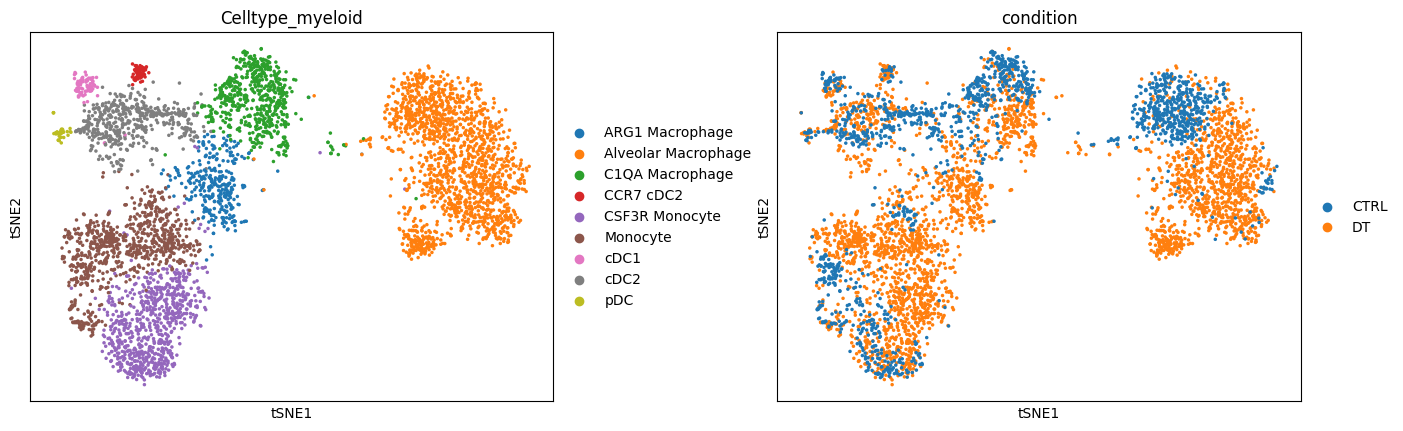

In [13]:
sc.pl.tsne(adata, color=["Celltype_myeloid", "condition"], wspace=0.3)

## Alternate visual

Let's visualize density differences based on distribution of cells on the tSNE space. This gives was a visual perspective of what the density differences look like:

In [14]:
df_temp = pd.DataFrame(
    {
        "tsne_x": adata.obsm["X_tsne"][:, 0],
        "tsne_y": adata.obsm["X_tsne"][:, 1],
        "condition": adata.obs["condition"],
    },
    index=adata.obs.index,
)

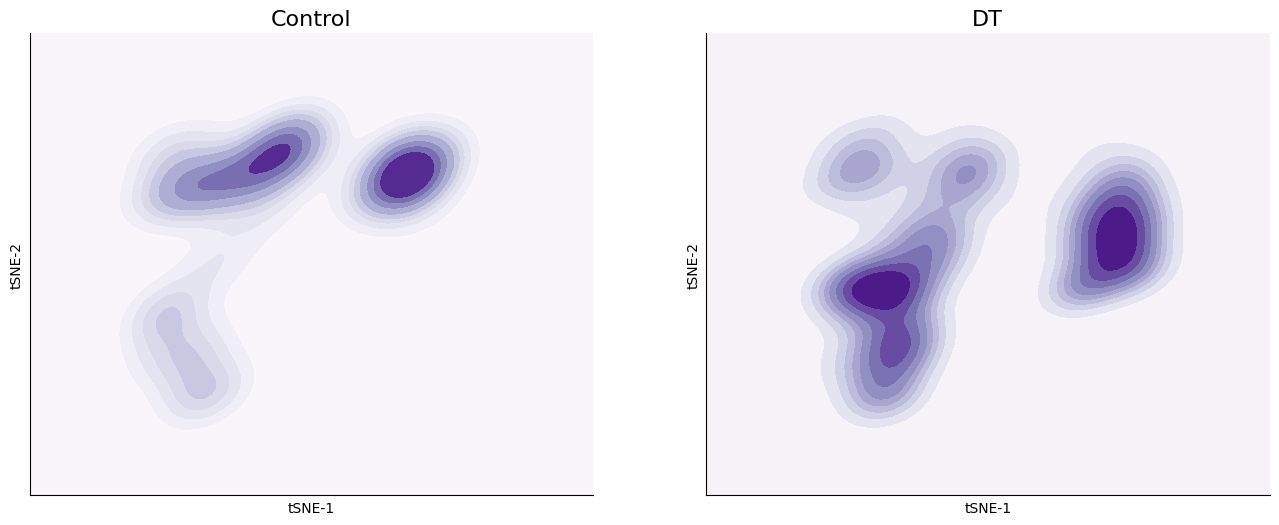

In [15]:
import seaborn as sns

fig = plt.figure(figsize=(8 * 2, 6))
ax = fig.add_subplot(1, 2, 1)
sns.scatterplot(data=df_temp, x="tsne_x", y="tsne_y", s=1, ax=ax)
sns.kdeplot(
    data=df_temp[df_temp["condition"] == "CTRL"],
    x="tsne_x",
    y="tsne_y",
    fill=True,
    thresh=0,
    levels=10,
    cmap="Purples",
    ax=ax,
    cut=4,
)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Control", fontsize=16)
ax.set_xlabel("tSNE-1")
ax.set_ylabel("tSNE-2")
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

ax = fig.add_subplot(1, 2, 2)
sns.scatterplot(data=df_temp, x="tsne_x", y="tsne_y", s=0, ax=ax)
sns.kdeplot(
    data=df_temp[df_temp["condition"] == "DT"],
    x="tsne_x",
    y="tsne_y",
    fill=True,
    thresh=0,
    levels=10,
    cmap="Purples",
    ax=ax,
    cut=4,
)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("DT", fontsize=16)
ax.set_xlabel("tSNE-1")
ax.set_ylabel("tSNE-2")
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
# fig.savefig(outbase + 'Ctrl_DT_kdeplot_endo.png', dpi = 150, bbox_inches = 'tight')

# MiloR

Milo is a statistical method to quantify changes in cellular abundancies in neighborhoods of cells in high-dimensional space. Given a data with cells from two conditions, Milo partitions the cell phenotype space in a set of (possibly overlapping) neighborhoods and allows quantification of differential abundances of cells from one condition compared to another in each neighborhood. It outputs associated logfoldchange between the two conditions, p-values and multiple comparisons adjusted p-values for each neighborhood. Furthermore, Milo allows one to annotate each neighborhood as a distinct celltype based on the proportion of cells from each celltype in the neighborhood. All of this is discussed in the code below. 

Milo's strength lies in detecting subtle `local` changes in cellular abundances. This is possible by the use of graphs and looking for changes in occupancy locally along the graph. 

For more details, please see the original publication: https://www.nature.com/articles/s41587-021-01033-z.

We will use the pertpy implementation of miloR from Python.

MiloR has been included in the more general perturbation analysis package called Pertpy: https://github.com/scverse/pertpy

## Import and setup pertpy

In [19]:
! pip install pertpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 627.0/627.0 kB 16.2 MB/s  0:00:00
  Preparing metadata (setup.py) ... done
  Using cached numpyro-0.19.0-py3-none-any.whl.metadata (37 kB)
  Using cached treescope-0.1.10-py3-none-any.whl.metadata (6.6 kB)
  Using cached etils-1.13.0-py3-none-any.whl.metadata (6.5 kB)
  Using cached humanize-4.13.0-py3-none-any.whl.metadata (7.8 kB)
  Using cached importlib_resources-6.5.2-py3-none-any.whl.metadata (3.9 kB)
  Using cached zipp-3.23.0-py3-none-any.whl.metadata (3.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 25.7 MB/s  0:00:00
Using cached treescope-0.1.10-py3-none-any.whl (182 kB)
Using cached numpyro-0.19.0-py3-none-any.whl (370 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 563.1/563.1 kB 14.8 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 20.9 MB/s  0:00:00 eta 0:00:01
Using cached etils-1.13.0-py3-none-any.whl (170 kB)
Using cached humanize-4.13.0-py3-none-any.whl (128 kB)
Using cached importlib_r

In [20]:
import pertpy as pt

milo = pt.tl.Milo()
# Create a milo object - note: milor requires mudata as input
mdata = milo.load(adata)

In [21]:
# compute neighbor graph
sc.pp.neighbors(mdata["rna"], n_neighbors=30, use_rep="X_pca")

In [22]:
# Make overlapping neighborhoods
milo.make_nhoods(
    mdata["rna"], neighbors_key=None, feature_key="rna", prop=0.1, seed=0, copy=False
)

In [23]:
# count cells in each neighborhood
mdata = milo.count_nhoods(mdata, sample_col="SampleID")

In [24]:
# Do differential abundance analysis using milo
milo.da_nhoods(mdata, design="~condition")

In [25]:
mdata["rna"]

AnnData object with n_obs × n_vars = 4718 × 12786
    obs: 'Clusters', 'Celltype', 'SampleID', 'name', 'background', 'condition', 'replicate', 'experiment', 'ncells', 'libsize', 'mito_fraction', 'ribo_fraction', 'mhc_fraction', 'actin_fraction', 'cytoskeleton_fraction', 'malat1_fraction', 'scrublet_predict', 'scrublet_score', 'lowlibsize', 'Clusters_myeloid', 'Celltype_myeloid', 'nhood_ixs_random', 'nhood_ixs_refined', 'nhood_kth_distance'
    uns: 'Celltype_myeloid_colors', 'condition_colors', 'neighbors', 'nhood_neighbors_key'
    obsm: 'X_pca', 'X_tsne', 'imputed_data', 'nhoods'
    layers: 'norm_count', 'norm_log'
    obsp: 'distances', 'connectivities'

## Visualize fold change on UMAP/tSNE

/Users/francesca.drummer/miniconda3/envs/workshop_2025/lib/python3.12/site-packages/anndata/_core/anndata.py:1175: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/francesca.drummer/miniconda3/envs/workshop_2025/lib/python3.12/site-packages/anndata/_core/anndata.py:1175: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/francesca.drummer/miniconda3/envs/workshop_2025/lib/python3.12/site-packages/anndata/_core/anndata.py:1175: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


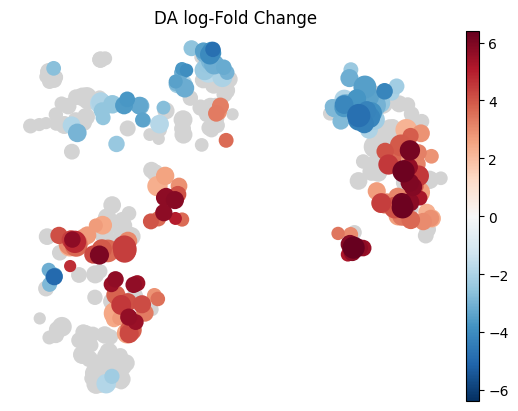

In [26]:
# Build graph and visualize it
milo.build_nhood_graph(mdata, basis="X_tsne")
milo.plot_nhood_graph(mdata)

In [27]:
mdata["rna"]

AnnData object with n_obs × n_vars = 4718 × 12786
    obs: 'Clusters', 'Celltype', 'SampleID', 'name', 'background', 'condition', 'replicate', 'experiment', 'ncells', 'libsize', 'mito_fraction', 'ribo_fraction', 'mhc_fraction', 'actin_fraction', 'cytoskeleton_fraction', 'malat1_fraction', 'scrublet_predict', 'scrublet_score', 'lowlibsize', 'Clusters_myeloid', 'Celltype_myeloid', 'nhood_ixs_random', 'nhood_ixs_refined', 'nhood_kth_distance'
    uns: 'Celltype_myeloid_colors', 'condition_colors', 'neighbors', 'nhood_neighbors_key'
    obsm: 'X_pca', 'X_tsne', 'imputed_data', 'nhoods'
    layers: 'norm_count', 'norm_log'
    obsp: 'distances', 'connectivities'

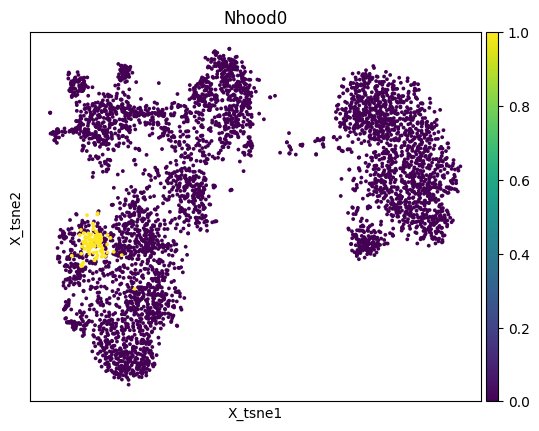

In [28]:
# Highlight a specific neighborhood
milo.plot_nhood(mdata, ix=0, basis="X_tsne")

## Visualize results as a beeswarm plot

/Users/francesca.drummer/miniconda3/envs/workshop_2025/lib/python3.12/site-packages/pertpy/tools/_milo.py:1012: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  nhood_adata.obs[[anno_col, "logFC"]].groupby(anno_col).median().sort_values("logFC", ascending=True).index
/Users/francesca.drummer/miniconda3/envs/workshop_2025/lib/python3.12/site-packages/pertpy/tools/_milo.py:1029: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/Users/francesca.drummer/miniconda3/envs/workshop_2025/lib/python3.12/site-packages/pertpy/tools/_milo.py:1029: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` fo

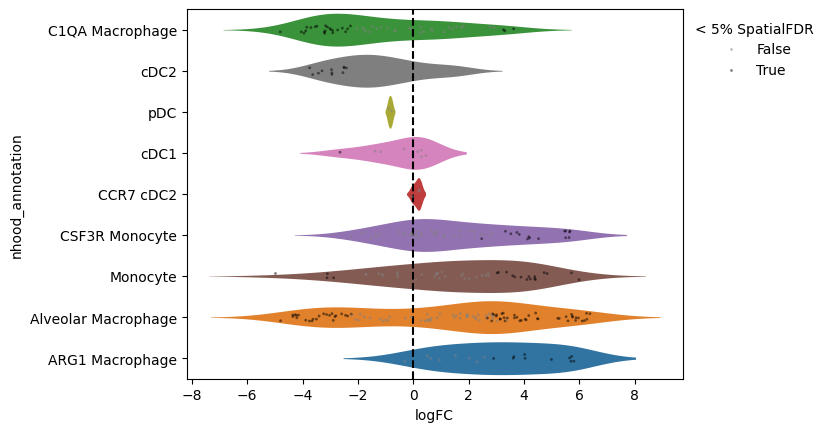

In [29]:
milo.annotate_nhoods(mdata, anno_col="Celltype_myeloid")
milo.plot_da_beeswarm(mdata, alpha=0.05)

In [30]:
mdata["rna"]

AnnData object with n_obs × n_vars = 4718 × 12786
    obs: 'Clusters', 'Celltype', 'SampleID', 'name', 'background', 'condition', 'replicate', 'experiment', 'ncells', 'libsize', 'mito_fraction', 'ribo_fraction', 'mhc_fraction', 'actin_fraction', 'cytoskeleton_fraction', 'malat1_fraction', 'scrublet_predict', 'scrublet_score', 'lowlibsize', 'Clusters_myeloid', 'Celltype_myeloid', 'nhood_ixs_random', 'nhood_ixs_refined', 'nhood_kth_distance', 'Nhood'
    uns: 'Celltype_myeloid_colors', 'condition_colors', 'neighbors', 'nhood_neighbors_key'
    obsm: 'X_pca', 'X_tsne', 'imputed_data', 'nhoods'
    layers: 'norm_count', 'norm_log'
    obsp: 'distances', 'connectivities'

## Alternate beeswarm visual

In [31]:
mdata["milo"]

AnnData object with n_obs × n_vars = 11 × 324
    obs: 'condition', 'SampleID'
    var: 'index_cell', 'kth_distance', 'logFC', 'logCPM', 'F', 'PValue', 'FDR', 'adjust.method', 'comparison', 'test', 'SpatialFDR', 'Nhood_size', 'nhood_annotation', 'nhood_annotation_frac'
    uns: 'sample_col', 'nhood', 'annotation_labels', 'annotation_obs'
    varm: 'X_milo_graph', 'frac_annotation'
    varp: 'nhood_connectivities'

/var/folders/sr/x0w569jx2ts65c68fz7_4c300000gn/T/ipykernel_21995/2798054379.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_yticklabels(cbar.ax.get_yticks(), fontsize=18)
/var/folders/sr/x0w569jx2ts65c68fz7_4c300000gn/T/ipykernel_21995/2798054379.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_yticklabels(cbar.ax.get_yticks(), fontsize=18)
/var/folders/sr/x0w569jx2ts65c68fz7_4c300000gn/T/ipykernel_21995/2798054379.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_yticklabels(cbar.ax.get_yticks(), fontsize=18)


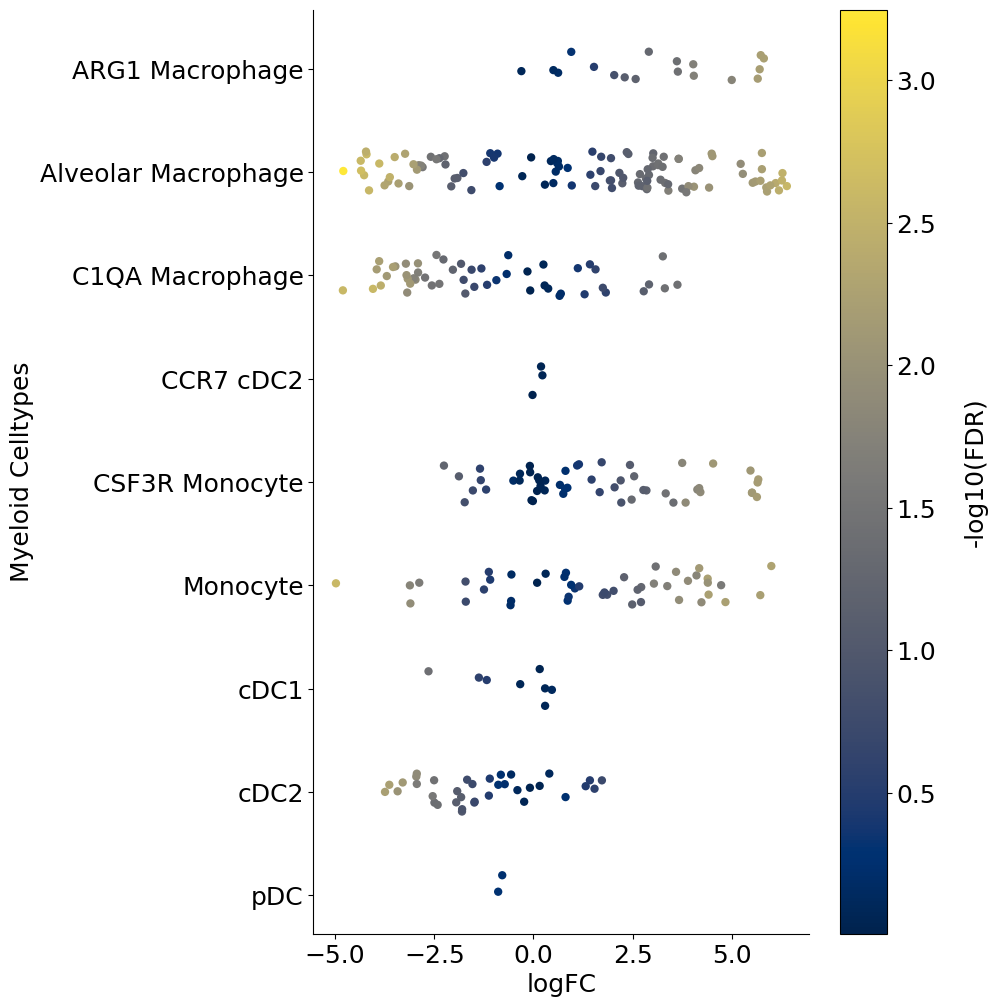

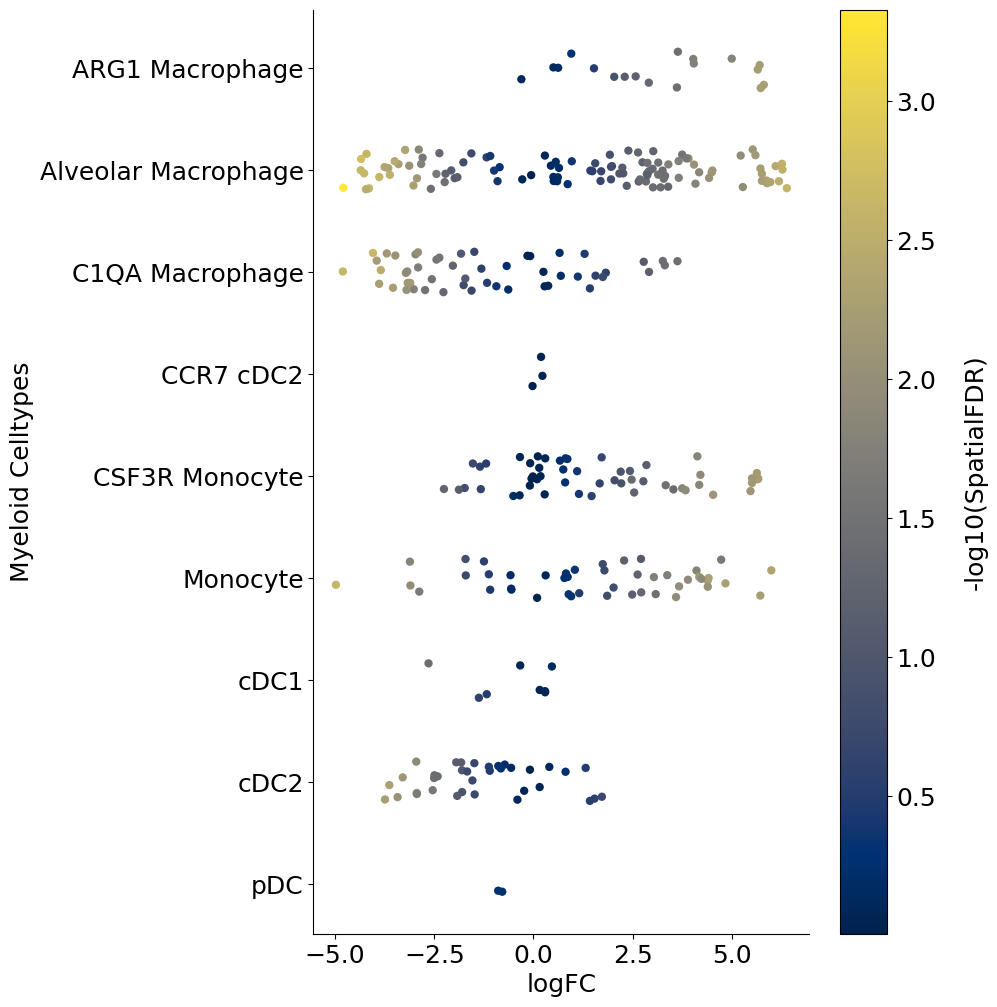

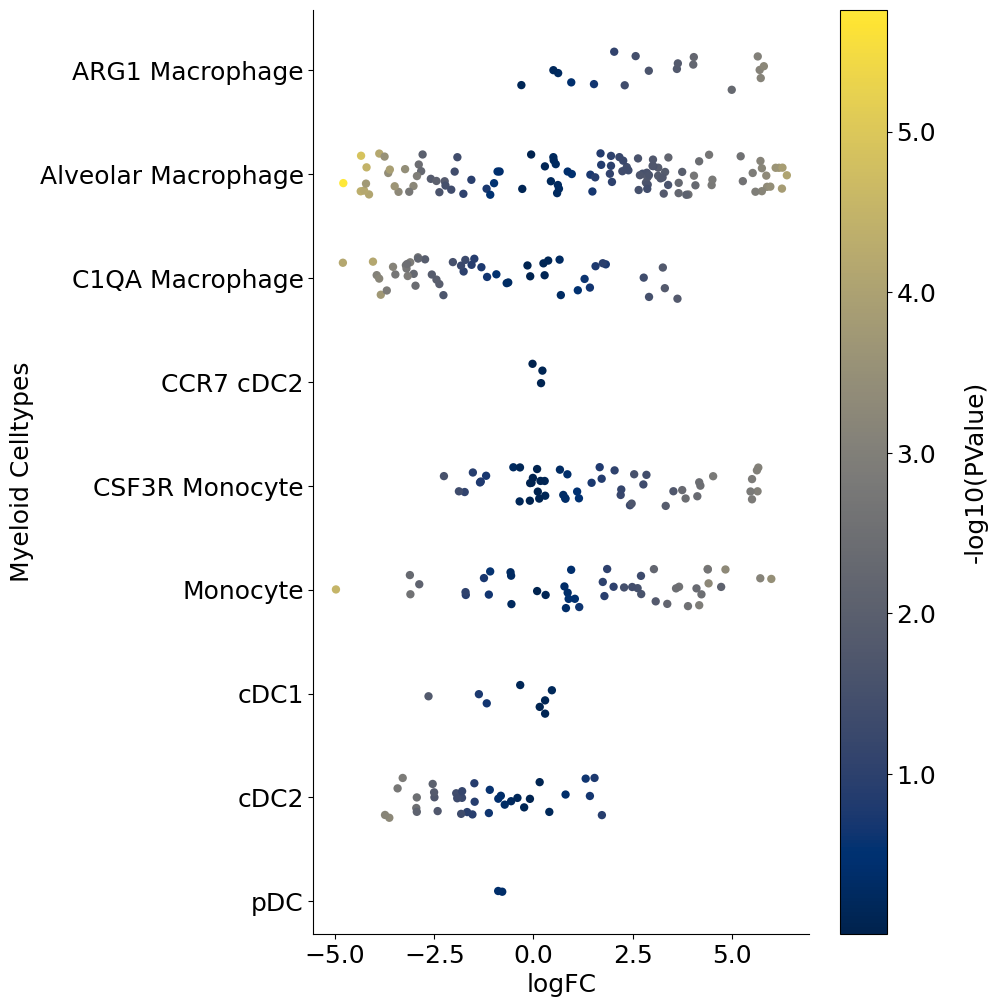

In [32]:
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

outbase = "/Users/sharmar1/Dropbox/msk_workshop/GSCN_2025/"

for j, item in enumerate(["FDR", "SpatialFDR", "PValue"]):
    fig = plt.figure(figsize=(8, 12))
    mdata["milo"].var["log_" + item] = -np.log10(mdata["milo"].var[item])
    ax = fig.add_subplot(1, 1, 1)
    plot = sns.stripplot(
        x="logFC",
        y="nhood_annotation",
        hue="log_" + item,
        data=mdata["milo"].var,
        size=6,
        palette="cividis",
        jitter=0.2,
        edgecolor="none",
        ax=ax,
    )
    plot.get_legend().set_visible(False)
    # ax.set_xticklabels(ax.get_xticks(), fontsize = 18)
    # ax.set_yticklabels(ax.get_yticks(), fontsize = 18)
    ax.tick_params(axis="both", which="major", labelsize=18)
    ax.set_ylabel("Myeloid Celltypes", fontsize=18)
    ax.set_xlabel("logFC", fontsize=18)
    sns.despine()

    # Drawing the side color bar
    normalize = mcolors.Normalize(
        vmin=mdata["milo"].var["log_" + item].min(),
        vmax=mdata["milo"].var["log_" + item].max(),
    )
    colormap = cm.cividis

    for n in mdata["milo"].var["log_" + item]:
        plt.plot(color=colormap(normalize(n)))

    scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
    scalarmappaple.set_array(mdata["milo"].var["log_" + item])
    cbar = fig.colorbar(scalarmappaple, ax=plt.gca())
    cbar.ax.set_yticklabels(cbar.ax.get_yticks(), fontsize=18)
    cbar.ax.set_ylabel("-log10(" + item + ")", labelpad=20, rotation=90, fontsize=18)
    ax.grid(False)
    # fig.savefig(outbase + 'milor_myeloid_swarmplot_colored_by_log_' + item + '.pdf', dpi = 300,
    #            bbox_inches = 'tight')